## First generate an image with Flux Schnell

In [1]:
import torch
from diffusers import FluxFillPipeline, FluxPipeline,DiffusionPipeline, FluxFillPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from utils import preprocess_image,pil_to_cv2,cv2_to_pil, show_image_cv2, clear_gpu_memory
import copy
import torch
from transformers import T5EncoderModel
from dust3r_infer import get_focals
from image_utils import *

GEN = False
IMAGE_SIZE = 1024
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

prompt = "a town square in a city with a person standing in the center"
image = pipe(
	prompt,
	guidance_scale=0.0,
	num_inference_steps=4,
	max_sequence_length=256,
	generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image.save("middle.jpg")
clear_gpu_memory()
focals = get_focals('middle.jpg', 512)
source_image_cv2 = pil_to_cv2(image)
show_image_cv2(source_image_cv2)



/home/cedric/anaconda3/envs/world_recipe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:

def shift_for_outpaint(source_image,frame_shift=300,offset=50,left=True):
	mask = torch.zeros((IMAGE_SIZE,IMAGE_SIZE), device='cpu') 
	if left : 
		mask[ :, :FILL_SHAPE] = 1 
	else:
		mask[:, -FILL_SHAPE:] = 1

	src_np = np.array(source_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
	shifted_image = np.ones((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8) * 255

	if left:
		shifted_image[:, -(frame_shift+offset):, :] = src_np[:, :(frame_shift+offset), :] 
	else:
		shifted_image[:, :frame_shift+offset, :] = src_np[:, -(frame_shift+offset):, :]
	if left:
		left_image = src_np[:, frame_shift:, :]
	else:
		left_image = src_np[:, -frame_shift:, :]
	shifted_pil = Image.fromarray(shifted_image)
	return shifted_pil, mask, left_image

def load_pipeline(four_bit=False):
	orig_pipeline = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
	print("Using four bit.")
	transformer = FluxTransformer2DModel.from_pretrained(
		"sayakpaul/FLUX.1-Fill-dev-nf4", subfolder="transformer", torch_dtype=torch.bfloat16
	)
	text_encoder_2 = T5EncoderModel.from_pretrained(
		"sayakpaul/FLUX.1-Fill-dev-nf4", subfolder="text_encoder_2", torch_dtype=torch.bfloat16
	)
	pipeline = FluxFillPipeline.from_pipe(
		orig_pipeline, transformer=transformer, text_encoder_2=text_encoder_2, torch_dtype=torch.bfloat16
	)

	pipeline.enable_model_cpu_offload()
	return pipeline


def get_new_image(image, source_image, fill_size,left=True,vis=True):
	image_cv2 = pil_to_cv2(image.copy())
	source_image_cv2 = pil_to_cv2(source_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
	image_cv2 = cv2.resize(image_cv2,(IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
	new_image = np.zeros((IMAGE_SIZE, IMAGE_SIZE+fill_size, 3), dtype=np.uint8)

	if left : 
		new_image[:, -IMAGE_SIZE:, :] = source_image_cv2
		new_image[:,:IMAGE_SIZE, :] = image_cv2
	else : 
		new_image[:, :IMAGE_SIZE, :] = source_image_cv2
		new_image[:, -IMAGE_SIZE:, :] = image_cv2
	if vis : 
		print('vis new image')
		show_image_cv2(new_image)
	return new_image
 
def generate_outpaint(pipe,image, source_image,offset=50,frame_shift=300, left=True,vis=False,use_flux=False):
	shifted_pil, mask, _ = shift_for_outpaint(source_image, frame_shift=frame_shift,offset=offset,left=left)
	print(pil_to_cv2(mask).shape)
	inp = mask.numpy().astype(np.uint8)[0]
	if use_flux:
		image = pipe(
			prompt="a city town square",
			image=preprocess_image(shifted_pil),
			mask_image=mask,
			height=IMAGE_SIZE,
			width=IMAGE_SIZE,
			guidance_scale=30,
			num_inference_steps=50,
			max_sequence_length=512,
			generator=torch.Generator("cpu").manual_seed(0)
		).images[0]
	else : 
		image = pipe(
			prompt="a city town square",
			image=preprocess_image(shifted_pil),
			mask_image=mask,
			height=IMAGE_SIZE,
			width=IMAGE_SIZE,
			max_sequence_length=512,
			generator=torch.Generator("cpu").manual_seed(0),
			).images[0]
	if vis:
		show_image_cv2(pil_to_cv2(image))
	return image

def fix_mask(image,source_image,fill_shape,offset,fill_size,left,vis=False):
	clear_gpu_memory()
	new_image = get_new_image(copy.deepcopy(image), copy.deepcopy(source_image), fill_size, left=left, vis=vis)

	mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE+fill_shape), dtype=np.uint8)
	mask_width = 10
	if left : 
		mask[:,IMAGE_SIZE + offset -mask_width:IMAGE_SIZE + offset +mask_width] = 1 
	else : 
		mask[:,fill_size-mask_width:mask_width+fill_size] = 1
	blur_amount = 50
	blurred_mask = cv2.GaussianBlur(mask*255, (blur_amount*2+1, blur_amount*2+1), 0) * 255
	blurred_mask = blurred_mask.astype(np.float32)
	image_gen = pipe(
		prompt="",
		image=preprocess_image(cv2_to_pil(new_image)),
		mask_image=blurred_mask,
		height=IMAGE_SIZE,
		width=IMAGE_SIZE+fill_shape,
		guidance_scale=40,
		num_inference_steps=10,
		max_sequence_length=512,
		generator=torch.Generator("cpu").manual_seed(0)
	).images[0]
	return image_gen


## Outpaint from the start Image

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]


Using four bit.


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
The module 'T5EncoderModel' has been loaded in `bitsandbytes` 4bit and conversion to torch.bfloat16 is not supported. Module is still in 4bit precision.
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 4bit and conversion to torch.bfloat16 is not supported. Module is still in 4bit precision.


(1024, 1024, 3)


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


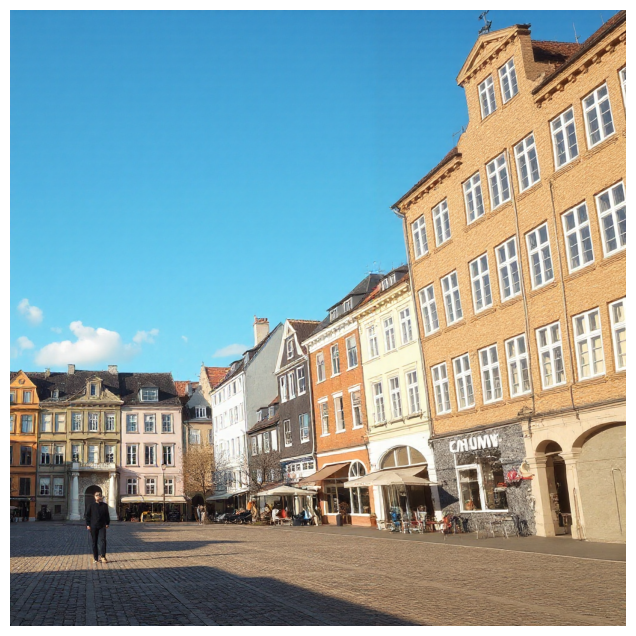

GPU memory cleared


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


(1024, 1024, 3)


 22%|██▏       | 11/50 [00:10<00:27,  1.42it/s]

In [ ]:
USE_FLUX = False
if USE_FLUX: 
	pipe = FluxFillPipeline.from_pretrained("black-forest-labs/FLUX.1-Fill-dev", torch_dtype=torch.bfloat16)
	pipe.enable_model_cpu_offload()
	pipe.enable_attention_slicing()
else : 
    pipe = load_pipeline()

source_image = image.copy()
left =  False
OFFSET = 50
FILL_SHAPE = 208 * 2
frame_shift = IMAGE_SIZE - FILL_SHAPE
FILL_SIZE = IMAGE_SIZE - frame_shift - OFFSET


image_left = generate_outpaint(pipe,image, source_image,offset=OFFSET,
                            frame_shift=frame_shift, left=left,vis=True,use_flux=USE_FLUX)
image_left = fix_mask(image_left,source_image,fill_shape=FILL_SHAPE,offset=OFFSET,fill_size=FILL_SIZE,left=left,vis=False)

image_right = generate_outpaint(pipe,image, source_image,offset=OFFSET,
                            frame_shift=frame_shift, left=True,vis=False,use_flux=USE_FLUX)
image_right = fix_mask(image_right,source_image,fill_shape=FILL_SHAPE,offset=OFFSET,fill_size=FILL_SIZE,left=True,vis=False)



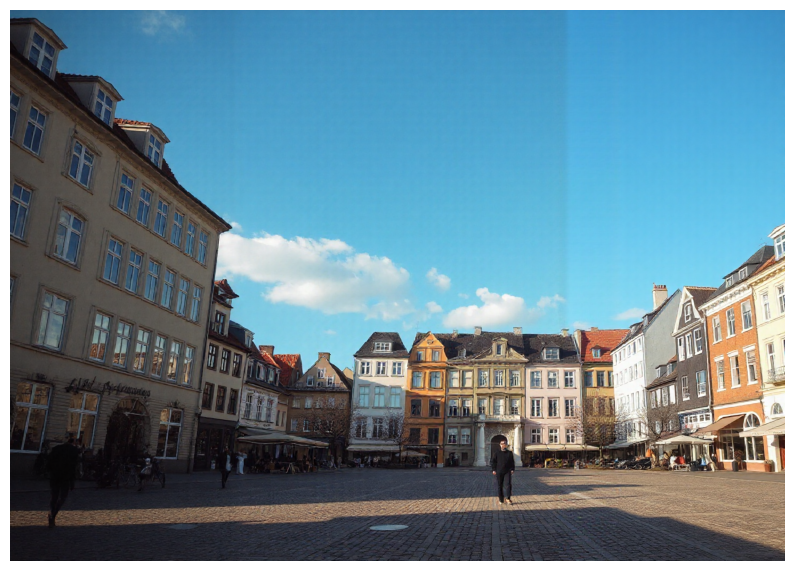

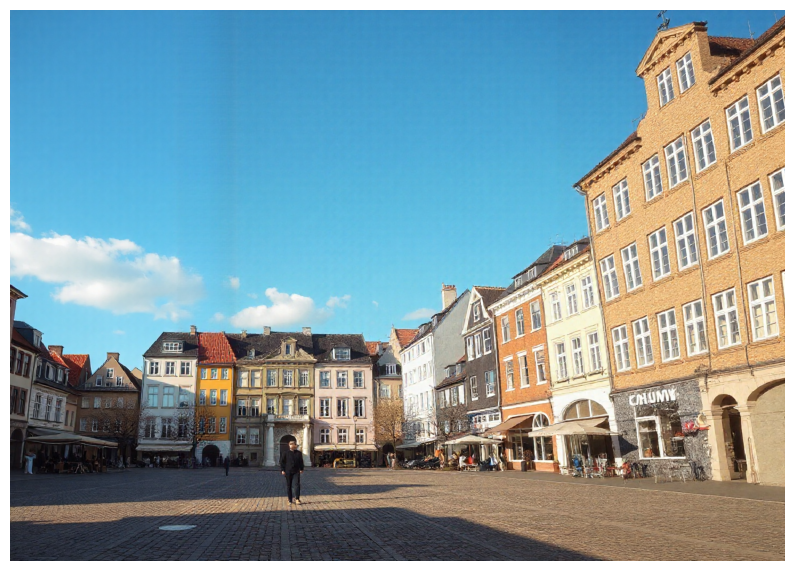

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
show_image_cv2(pil_to_cv2(image_right))
show_image_cv2(pil_to_cv2(image_left))
concat_image = cv2.hconcat([pil_to_cv2(image_right)[:,:-512,:],pil_to_cv2(image_left)[:,512+OFFSET/2:,:]])
print(concat_image.shape)	
show_image_cv2(concat_image)